In [4]:
!pip install pandas_ta

In [33]:
import yfinance as yf
import pandas as pd
import os
import pandas_ta as ta

In [34]:
def data(ticker):
  df = yf.Ticker(ticker)
  df = df.history(period="max")
  df.index = pd.to_datetime(df.index)
  del df["Dividends"]
  del df["Stock Splits"]
  df = df.loc["2014-01-01":].copy()
  df["Target"] = (df["Close"] > df["Open"]).astype(int).shift(-1)   ##Binary target...tomorrow increase or decrease direction as an output to be decided by todays statistics
  # frequency = df['Target'].value_counts()
  # print(frequency)
  df.dropna(inplace=True)
  return df

In [35]:
nifty=data("^NSEI")

In [36]:
nifty

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2014-01-02 00:00:00+05:30,6301.250000,6358.299805,6211.299805,6221.149902,158100,1.0
2014-01-03 00:00:00+05:30,6194.549805,6221.700195,6171.250000,6211.149902,139000,0.0
2014-01-06 00:00:00+05:30,6220.850098,6224.700195,6170.250000,6191.450195,118300,0.0
2014-01-07 00:00:00+05:30,6203.899902,6221.500000,6144.750000,6162.250000,138600,0.0
2014-01-08 00:00:00+05:30,6178.049805,6192.100098,6160.350098,6174.600098,146900,0.0
...,...,...,...,...,...,...
2024-07-09 00:00:00+05:30,24351.000000,24443.599609,24331.900391,24433.199219,250500,0.0
2024-07-10 00:00:00+05:30,24459.849609,24461.050781,24141.800781,24324.449219,292300,0.0
2024-07-11 00:00:00+05:30,24396.550781,24402.650391,24193.750000,24315.949219,306400,1.0


<Axes: xlabel='Date'>

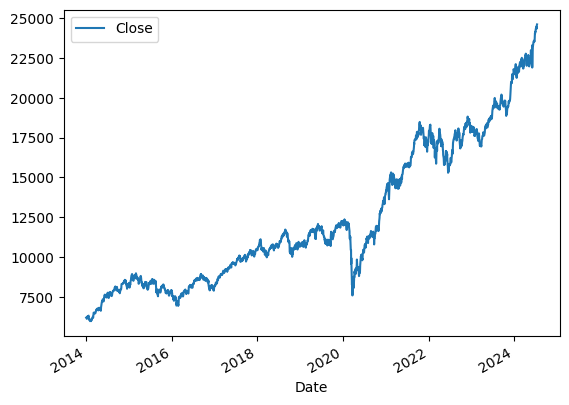

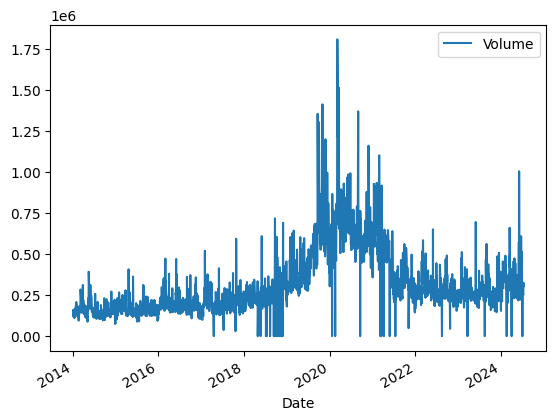

In [37]:
nifty.plot.line(y="Close", use_index=True)
nifty.plot.line(y="Volume", use_index=True)

**First we are going to make a simple model with less features using random forest classifier of sklearn module**(which will predict whether the stock price will go up(1) or down(0) tomorrow) :

In [119]:
nifty=data("^NSEI")
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300, min_samples_split=2, random_state=50,n_jobs=-1)
train= nifty.iloc[:-200]
test = nifty.iloc[-200:-1]
features = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[features], train["Target"])
print(model.feature_importances_)
print("Training score",model.score(train[features], train["Target"]))

[0.19964844 0.21809386 0.19650632 0.19300089 0.1927505 ]
Training score 1.0


Following are the results of the predictions of the model whether stock price will increase or decrease tomorrow using only "Close", "Volume", "Open", "High", "Low" prices of today :


In [120]:
from sklearn.metrics import accuracy_score

prediction = model.predict(test[features])
prediction = pd.Series(prediction, index=test.index)
print("Accuracy Score",accuracy_score(test["Target"], prediction))

Accuracy Score 0.5376884422110553


**For the following model, various indicators will be used (using pandas_ta) :**

In [132]:
# Calculating technical indicators using pandas_ta
nifty=data("^NSEI")
nifty['SMA_10'] = ta.sma(nifty['Close'], length=10)
nifty['EMA_10'] = ta.ema(nifty['Close'], length=10)
nifty['RSI_14'] = ta.rsi(nifty['Close'], length=14)
macd = ta.macd(nifty['Close'])
nifty['MACD'] = macd['MACD_12_26_9']
nifty['MACD_signal'] = macd['MACDs_12_26_9']
nifty['MACD_hist'] = macd['MACDh_12_26_9']
nifty['ATR'] = ta.atr(nifty['High'], nifty['Low'], nifty['Close'], length=14)
nifty['OBV'] = ta.obv(nifty['Close'], nifty['Volume'])
bbands = ta.bbands(nifty['Close'], length=20)
nifty['Upper_BB'] = bbands['BBU_20_2.0']
nifty['Middle_BB'] = bbands['BBM_20_2.0']
nifty['Lower_BB'] = bbands['BBL_20_2.0']

# Lagged features (kind of last five rows to predict the next row)
# for lag in range(1, 6):  # Example: 1 to 5 days lag
#     # lag-=1
#     nifty[f'Close_t-{lag}'] = nifty['Close'].shift(lag)
#     nifty[f'Open_t-{lag}'] = nifty['Open'].shift(lag)
#     nifty[f'High_t-{lag}'] = nifty['High'].shift(lag)
#     nifty[f'Low_t-{lag}'] = nifty['Low'].shift(lag)
#     nifty[f'Volume_t-{lag}'] = nifty['Volume'].shift(lag)

# NaN values will be obviously generated by shifting
nifty = nifty.dropna()

nifty

,Open,High,Low,Close,Volume,Target,SMA_10,EMA_10,RSI_14,MACD,MACD_signal,MACD_hist,ATR,OBV,Upper_BB,Middle_BB,Lower_BB
Date,,,,,,,,,,,,,,,,,
2014-02-19 00:00:00+05:30,6132.049805,6160.350098,6125.750000,6152.750000,95200,0.0,6065.135059,6086.767606,53.324903,-49.153151,-72.714650,23.561500,65.909528,127000.0,6306.530687,6107.547534,5908.564381
2014-02-20 00:00:00+05:30,6127.149902,6129.100098,6086.450195,6091.450195,132100,1.0,6072.040088,6087.618986,46.788779,-45.287959,-67.229312,21.941353,65.939845,-5100.0,6263.470244,6095.172534,5926.874824
2014-02-21 00:00:00+05:30,6108.299805,6159.649902,6108.000000,6155.450195,112600,1.0,6083.955127,6099.951933,53.233846,-36.638160,-61.111082,24.472922,66.114302,107500.0,6212.710795,6085.662549,5958.614303
2014-02-24 00:00:00+05:30,6140.950195,6191.850098,6130.799805,6186.100098,144900,0.0,6096.245117,6115.615236,55.983473,-26.998716,-54.288609,27.289892,65.725613,252400.0,6189.032195,6081.630054,5974.227912
2014-02-25 00:00:00+05:30,6205.700195,6216.850098,6176.600098,6200.049805,146300,1.0,6110.905078,6130.966976,57.216407,-18.025971,-47.036081,29.010110,63.780586,398700.0,6201.932690,6084.840039,5967.747389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-09 00:00:00+05:30,24351.000000,24443.599609,24331.900391,24433.199219,250500,0.0,24185.594922,24159.562681,74.134418,388.053851,360.463521,27.590330,229.509772,73659700.0,24595.096743,23835.469922,23075.843101
2024-07-10 00:00:00+05:30,24459.849609,24461.050781,24141.800781,24324.449219,292300,0.0,24231.159766,24189.542051,69.275641,377.548149,363.880447,13.667702,235.919788,73367400.0,24629.060485,23888.449902,23147.839319
2024-07-11 00:00:00+05:30,24396.550781,24402.650391,24193.750000,24315.949219,306400,1.0,24258.304688,24212.525173,68.895564,364.336580,363.971673,0.364907,233.989831,73061000.0,24653.107926,23938.099902,23223.091879


Lets firstly define all of these things features...later we will find which ones are more important(or all of them are :)


In [179]:
# Define features and target variable
featuresl = [
    'Close_t-1', 'Close_t-2', 'Close_t-3', 'Close_t-4', 'Close_t-5',
    'Open_t-1', 'High_t-1', 'Low_t-1', 'Volume_t-1',
    'SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist',
    'ATR', 'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB',
]
featuresq =['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist',
    'ATR', 'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB','Open','High','Low','Close','Volume']  ##without lagged features
features =['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal','Middle_BB','Open','Close','Volume']  ##without lagged features
X = nifty[featuresq]
y = nifty['Target']  # Binary target: 0 for price decrease, 1 for price increase

Lets now build the model, using same parameters(later will tune them too) :

In [201]:
# Train-test split while maintaining the temporal order
train_size = int(len(X) * 0.95)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
model = RandomForestClassifier(n_estimators=9985, min_samples_split=17, random_state=6,min_samples_leaf=1,max_features=10,n_jobs=-1)
model.fit(X_train, y_train)
print(model.feature_importances_)
#Training set results
prediction = model.predict(X_train)
prediction = pd.Series(prediction, index=X_train.index)
df=pd.concat([y_train, prediction], axis=1)
# display(df)
print("Accuracy Score",accuracy_score(y_train, prediction))

[0.0362164  0.03046393 0.10484576 0.08234461 0.08446722 0.10354353
 0.0943319  0.071024   0.04513774 0.03600626 0.05107864 0.04011096
 0.03288228 0.03333486 0.04051899 0.11369291]
Accuracy Score 0.9694593479158069


In [202]:
#Testing set results
prediction = model.predict(X_test)
prediction = pd.Series(prediction, index=X_test.index)
df=pd.concat([y_test, prediction], axis=1)
# display(df)
print("Accuracy Score",accuracy_score(y_test, prediction))

Accuracy Score 0.4609375


Now parameter tuning:


In [109]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [110]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [111]:
predictions = backtest(nifty, model, predictors)

In [112]:
predictions["Predictions"].value_counts()

Predictions
0.0    66
1.0    17
Name: count, dtype: int64

In [113]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7058823529411765

In [114]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0.0    0.518072
1.0    0.481928
Name: count, dtype: float64

In [115]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nifty.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    nifty[ratio_column] = nifty["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    nifty[trend_column] = nifty.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [116]:
nifty = nifty.dropna(subset=nifty.columns[nifty.columns != "Tomorrow"])

In [117]:
nifty

,Open,High,Low,Close,Volume,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,
2018-02-06 00:00:00+05:30,10295.150391,10594.150391,10276.299805,10498.250000,266500,0.0,0.992048,2.0,0.972601,3.0,0.999308,28.0,1.069326,109.0,1.248983,449.0
2018-02-07 00:00:00+05:30,10607.200195,10614.000000,10446.400391,10476.700195,250400,1.0,0.998973,1.0,0.980616,2.0,0.997012,27.0,1.066376,108.0,1.245787,448.0
2018-02-08 00:00:00+05:30,10518.500000,10637.799805,10479.549805,10576.849609,232200,1.0,1.004757,1.0,0.998212,3.0,1.005981,28.0,1.075792,108.0,1.257041,449.0
2018-02-09 00:00:00+05:30,10416.500000,10480.200195,10398.200195,10454.950195,191600,1.0,0.994204,2.0,0.992434,4.0,0.993964,29.0,1.062665,109.0,1.241920,450.0
2018-02-12 00:00:00+05:30,10518.200195,10555.500000,10485.400391,10539.750000,217400,0.0,1.004039,2.0,1.002897,4.0,1.001357,30.0,1.070513,110.0,1.251344,451.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08 00:00:00+05:30,24329.449219,24344.599609,24240.550781,24320.550781,266300,1.0,0.999932,1.0,1.002026,1.0,1.060941,26.0,1.150728,127.0,1.407333,506.0
2024-07-09 00:00:00+05:30,24351.000000,24443.599609,24331.900391,24433.199219,250500,0.0,1.002311,1.0,1.004108,2.0,1.064470,27.0,1.154912,127.0,1.412697,507.0
2024-07-10 00:00:00+05:30,24459.849609,24461.050781,24141.800781,24324.449219,292300,0.0,0.997770,1.0,0.999327,2.0,1.058525,26.0,1.148685,126.0,1.405268,506.0


In [118]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [119]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [120]:
predictions = backtest(nifty, model, new_predictors)

ValueError: No objects to concatenate

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
predictions